<h1 align="center">Naive Bayes</h1>

In this notebook, we will convert criteria sentence to feature vector by Bert-as-Service, train Naive Bayes model for criteria sentence classification, and evalute the performance in test data.

* training data (30644 sentences), test data (7697 sentences)
* 44 semantic categories

|#|group topics|semantic categories|
|---|---|----
|1|`Health Status`|`Disease` `Symptom` `Sign` `Pregnancy-related Activity` `Neoplasm Status` `Non-Neoplasm Disease Stage` `Allergy Intolerance` `Organ or Tissue Status` `Life Expectancy` `Oral related`
|2|`Treatment or Health Care`|`Pharmaceutical Substance or Drug` `Therapy or Surgery` `Device` `Nursing`
|3|`Diagnostic or Lab Test`|`Diagnostic` `Laboratory Examinations` `Risk Assessment` `Receptor Status`
|4|`Demographic Characteristics`|`Age` `Special Patient Characteristic` `Literacy` `Gender` `Education` `Address` `Ethnicity`
|5|`Ethical Consideration`|`Consent` `Enrollment in other studies` `Researcher Decision` `Capacity` `Ethical Audit` `Compliance with Protocol`
|6|`Lifestyle Choice`|`Addictive Behavior` `Bedtime` `Exercise` `Diet` `Alcohol Consumer` `Sexual related` `Smoking Status` `Blood Donation`
|7|`Data or Patient Source`|`Encounter` `Disabilities` `Healthy` `Data Accessible`
|8|`Other`|`Multiple`

In [9]:
from __future__ import division

import os
import codecs
import time 
import math
import pickle
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics

%matplotlib inline 
import matplotlib.pyplot as plt

<h2>Bert-as-service</h2>

***

download bert-as-service

``` 
pip install bert-serving-server  # server
pip install bert-serving-client  # client, independent of `bert-serving-server
```

start bert-as-service in terminal

```
bert-serving-start -model_dir chinese_L-12_H-768_A-12 -num_worker=4
```

run bert-as-service

In [2]:
from bert_serving.client import BertClient
bc = BertClient()

v = bc.encode(["4.年龄小于65岁。", "存在严重的合并症者"])
print(v)
print(len(v[0]))

[[ 0.84583086 -0.46175382  0.40942535 ...  0.21331571  0.11204454
  -0.12961882]
 [ 0.04718163  0.455918    0.2500301  ... -0.12850839 -0.2012489
  -0.03303002]]
768


<h2>Load data from file and convert criteria sentence to feature matrix</h2>

***

In [3]:
from bert_serving.client import BertClient
bc = BertClient()
tags = ["Disease","Symptom","Sign","Pregnancy-related Activity","Neoplasm Status","Non-Neoplasm Disease Stage",
        "Allergy Intolerance","Organ or Tissue Status","Life Expectancy","Oral related",
        "Pharmaceutical Substance or Drug","Therapy or Surgery","Device","Nursing","Diagnostic",
        "Laboratory Examinations","Risk Assessment","Receptor Status","Age","Special Patient Characteristic",
        "Literacy","Gender","Education","Address","Ethnicity","Consent","Enrollment in other studies",
        "Researcher Decision","Capacity","Ethical Audit","Compliance with Protocol","Addictive Behavior",
        "Bedtime","Exercise","Diet","Alcohol Consumer","Sexual related","Smoking Status","Blood Donation",
        "Encounter","Disabilities","Healthy","Data Accessible","Multiple"]

def _get_feature_matrix(infile):
    X, y = [], []
    criteria_sentences = []
    with open(infile, "r", encoding="utf-8") as inf:
        for line in inf:
            l = line.strip().split("\t")
            criteria_category = l[1]
            criteria_sentence = l[2]
            criteria_sentences.append(criteria_sentence)
            y.append(tags.index(criteria_category))
    X = bc.encode(criteria_sentences)
    return np.array(X), np.array(y)

In [4]:
train_data_file = "../data/train_data.txt"
X_train, y_train = _get_feature_matrix(train_data_file)
print('Train set:', X_train.shape,  y_train.shape)

C:\Users\310272293\AppData\Local\Continuum\anaconda3\lib\site-packages\bert_serving\client\__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


Train set: (30644, 768) (30644,)


In [5]:
test_data_file = "../data/test_data.txt"
X_test, y_test = _get_feature_matrix(test_data_file)
print ('Test set:', X_test.shape,  y_test.shape)

Test set: (7697, 768) (7697,)


<h2>Modeling (Naive Bayes with Scikit-learn)</h2>

***

<h3>What about other Naive Bayes?</h3>
Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable

<ul>
    <li>GaussianNB</li>
      implements the Gaussian Naive Bayes algorithm for classification.
    <li>Multinomial Naive Bayes</li>
      MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification
    <li>Complement Naive Bayes</li>
    ComplementNB implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets
    <li>Bernoulli Naive Bayes</li>
    BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions
    <li>Categorical Naive Bayes</li>
    CategoricalNB implements the categorical naive Bayes algorithm for categorically distributed data.
</ul
    
<b>we used GaussianNB and BernoulliNB, because the other NB models need the X has no negtive values.</b>

<h4>select NB classifier with best accuracy</h4>

In [15]:
classifier = {'GaussianNB':GaussianNB(), 'BernoulliNB':BernoulliNB()}

mean_acc = np.zeros((2))
std_acc = np.zeros((2))
n = 0
for k,v in classifier.items():
    print(k)
    #Train Model and Predict  
    model = v.fit(X_train,y_train)
    yhat=model.predict(X_test)

    mean_acc[n] = metrics.accuracy_score(y_test, yhat)
    std_acc[n]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    n +=1

mean_acc

GaussianNB
BernoulliNB


array([0.61348577, 0.60958815])

<h4>plot  model accuracy  for Different number of Neighbors</h4>

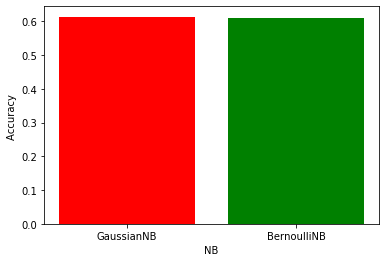

In [28]:
NB_models = ['GaussianNB', 'BernoulliNB']
plt.bar(range(len(mean_acc)), mean_acc,color='rgb',tick_label=NB)
plt.ylabel('Accuracy ')
plt.xlabel('NB')
plt.show()

In [29]:
print( "The best accuracy was with", mean_acc.max(), "with NB=", NB_models[mean_acc.argmax()])

The best accuracy was with 0.6134857736780563 with NB= GaussianNB


<h3>Train</h3>

In [30]:
NB = GaussianNB().fit(X_train,y_train)
NB

GaussianNB(priors=None, var_smoothing=1e-09)

<h3>Predict</h3>

In [31]:
ypredict_test = NB.predict(X_test)
ypredict_test

array([18, 43,  0, ..., 36, 36, 36])

<h3>Confusion matrix</h3>

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, ypredict_test, labels=list(range(len(tags)))))

[[1075   60  111 ...    1    0   41]
 [   4   28    7 ...    1    0    2]
 [   8   17   41 ...    2    0    1]
 ...
 [   0    0    0 ...   10    0    2]
 [   0    0    0 ...    0   19    0]
 [ 208   12   48 ...   14    5  115]]


Confusion matrix, without normalization
[[1075   60  111 ...    1    0   41]
 [   4   28    7 ...    1    0    2]
 [   8   17   41 ...    2    0    1]
 ...
 [   0    0    0 ...   10    0    2]
 [   0    0    0 ...    0   19    0]
 [ 208   12   48 ...   14    5  115]]


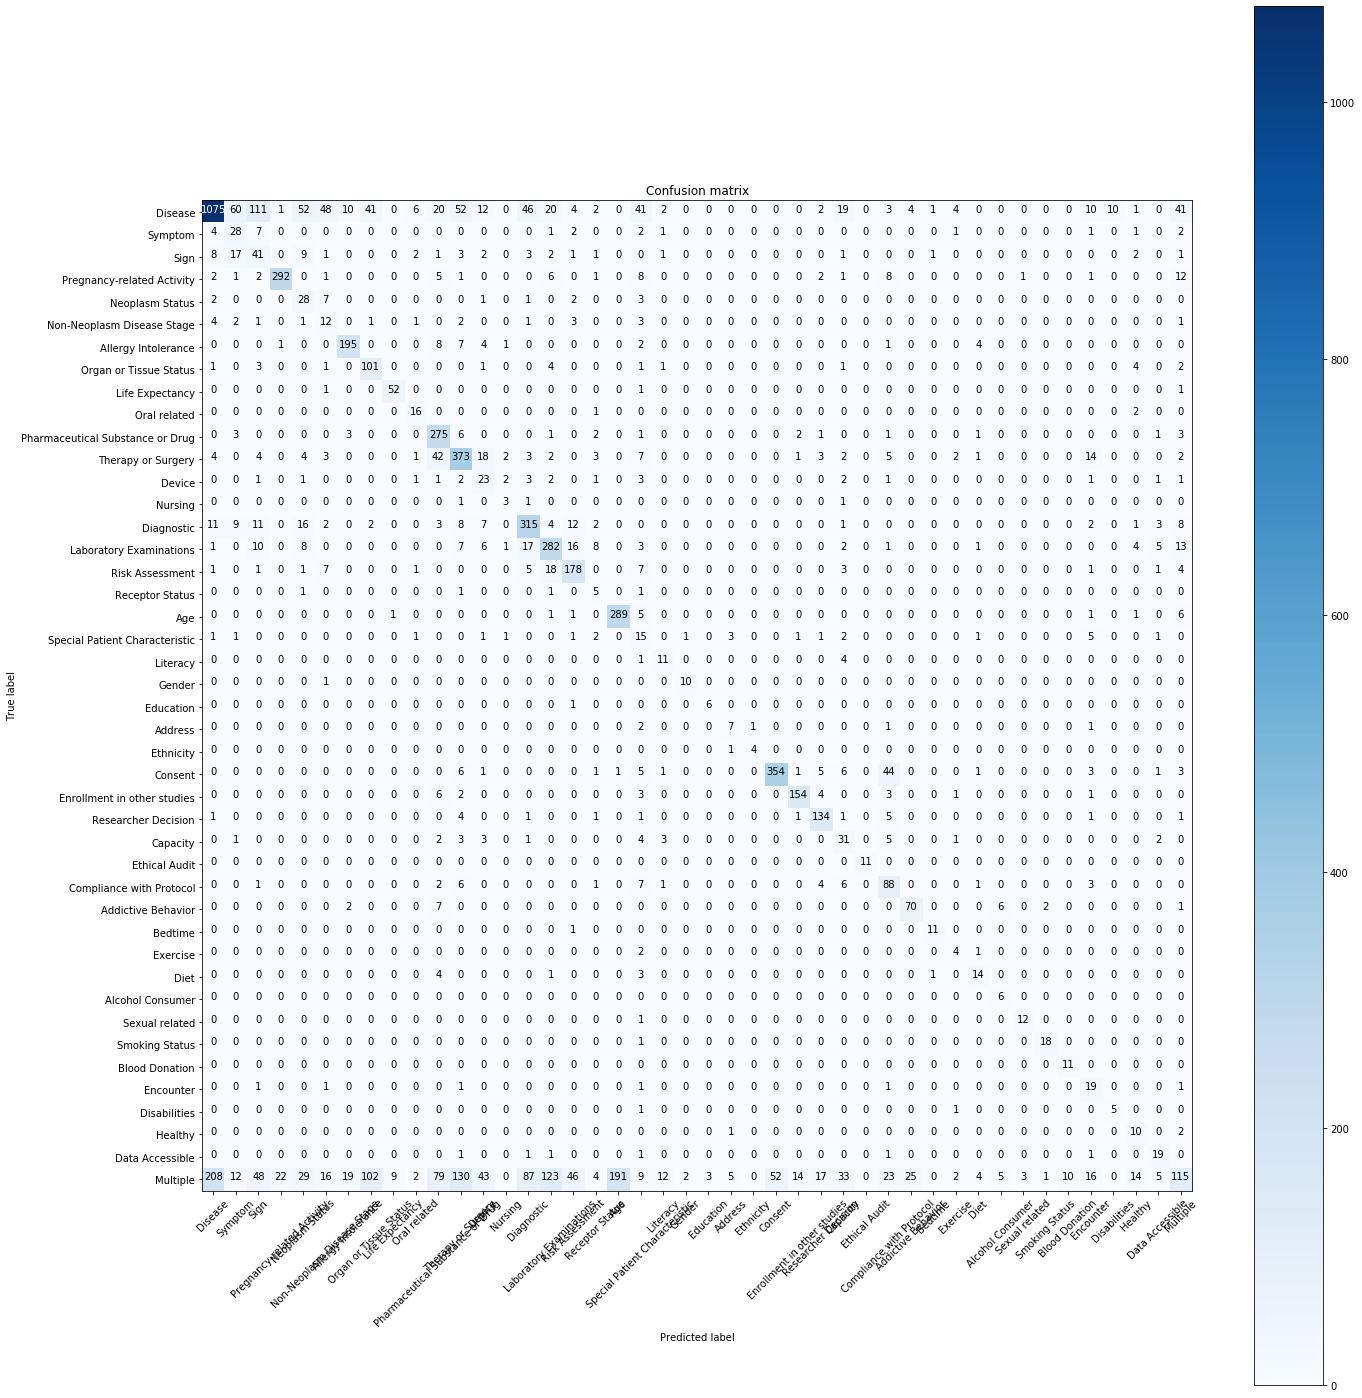

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, ypredict_test, labels=list(range(len(tags))))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=tags,normalize= False,  title='Confusion matrix')

<h2>Save model and test data results</h2>

***

In [35]:
model_save_file = "NB.pickle"
with open(model_save_file, 'wb') as f:
    pickle.dump(NB, f)

In [36]:
test_data_file = "../data/test_data.txt"
test_results_save_file = "test_data_predict.txt"

criteria_ids, criteria_sentences = [], []
with open(test_data_file, "r", encoding="utf-8") as inf:
    for line in inf:
        l = line.strip().split("\t")
        criteria_ids.append(l[0])
        criteria_sentences.append(l[2])

with codecs.open(test_results_save_file, "w", encoding="utf-8") as outf:
    for i in range(len(criteria_ids)):
        outf.write("{}\t{}\t{}\n".format(criteria_ids[i], tags[ypredict_test[i]], criteria_sentences[i]))

<h2>Evaluation</h2>

---

In [37]:
test_data_file = "../data/test_data.txt"
test_results_save_file = "test_data_predict.txt"
test_results_evaluation_save_file = "test_data_evaluation.txt"
os.system("python evaluation.py {} {} > {}".format(test_data_file, test_results_save_file, test_results_evaluation_save_file))

0

In [39]:
with open(test_results_evaluation_save_file, "r") as f:
    for line in f:
        print(line.strip("\n"))

**************************************** Evaluation results*****************************************
                                       Precision.       Recall.          f1.            
                 Addictive Behavior    0.7071           0.7955           0.7487         
                            Address    0.4118           0.5833           0.4828         
                                Age    0.6008           0.9475           0.7354         
                   Alcohol Consumer    0.3529           1.0000           0.5217         
                Allergy Intolerance    0.8515           0.8744           0.8628         
                            Bedtime    0.7857           0.9167           0.8462         
                     Blood Donation    0.5238           1.0000           0.6875         
                           Capacity    0.2672           0.5536           0.3605         
           Compliance with Protocol    0.4607           0.7333           0.5659         
         

<h2>Predict a new input criteria sentence with saved model</h2>

***

In [41]:
# new example
s = ["男女皆有", "年龄大于18岁，", "病人对研究药物过敏。"]

# get feature
from bert_serving.client import BertClient
bc = BertClient()
f = bc.encode(s)

# loads models
loaded_model = pickle.load(open("NB.pickle", "rb"))

# predict
results = loaded_model.predict(f)
predict_tags = [tags[i] for i in results]

print(predict_tags)

['Gender', 'Age', 'Allergy Intolerance']
